- did logreg with part of the data for sex and all for adhd
- did one decision tree

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load in data

In [31]:
file_path_trainC = "widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.csv"
train_cat = pd.read_csv(file_path_trainC)

file_path_trainFCM = "widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
train_FCM = pd.read_csv(file_path_trainFCM)

file_path_trainQ = "widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.csv"
train_Quant = pd.read_csv(file_path_trainQ)

file_path_trainS = "widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.csv"
train_Solutions = pd.read_csv(file_path_trainS)
train_Solutions.drop(columns = ['Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [32]:
file_path_testC = "widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx"
test_cat = pd.read_excel(file_path_testC)

file_path_testFCM = "widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_FCM = pd.read_csv(file_path_testFCM)

file_path_testQ = "widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx"
test_Quant = pd.read_excel(file_path_testQ)

## Combine train and test categorical data sets in order to get summative one hot encoding

In [33]:
train_cat = train_cat.drop(columns = 'Basic_Demos_Enroll_Year')

In [34]:
train_shape = train_cat.shape

for col in train_cat.select_dtypes(include = 'number').columns:
    train_cat[col] = train_cat[col].astype('Int64')
    train_cat[col] = train_cat[col].astype('category')
    
for col in test_cat.select_dtypes(include = 'number').columns:
    test_cat[col] = test_cat[col].astype('Int64')
    test_cat[col] = test_cat[col].astype('category')
    
cat_train_test = pd.concat([train_cat, test_cat], axis = 0).reset_index(drop = True)
columns_to_encode = cat_train_test.columns[1:].tolist()
cat_train_test_final = cat_train_test.drop(columns = columns_to_encode)

for col in cat_train_test.columns[1:]:
    encoded = pd.get_dummies(cat_train_test[col], prefix = col)
    cat_train_test_final = pd.concat([cat_train_test_final, encoded], axis = 1)

cat_train_test_final.head()

,participant_id,Basic_Demos_Study_Site_1,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,Basic_Demos_Study_Site_5,PreInt_Demos_Fam_Child_Ethnicity_0,PreInt_Demos_Fam_Child_Ethnicity_1,PreInt_Demos_Fam_Child_Ethnicity_2,PreInt_Demos_Fam_Child_Ethnicity_3,...,Barratt_Barratt_P2_Occ_25,Barratt_Barratt_P2_Occ_30,Barratt_Barratt_P2_Occ_35,Barratt_Barratt_P2_Occ_40,Barratt_Barratt_P2_Occ_45,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Enroll_Year_2021,Basic_Demos_Enroll_Year_2022,Basic_Demos_Enroll_Year_2023
0,UmrK0vMLopoR,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,CPaeQkhcjg7d,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nb4EetVPm3gs,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,p4vPhVu91o4b,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M09PXs7arQ5E,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split back into training and testing sets and combine with quantitative and FCM data

In [35]:
cat_train_final = cat_train_test_final.iloc[0:train_shape[0]]
cat_test_final = cat_train_test_final.iloc[train_shape[0]:]

In [36]:
logreg_sex = pd.merge(train_FCM, train_Quant, on = 'participant_id')
train_df = pd.merge(cat_train_final, logreg_sex, on = 'participant_id')

# ensure it looks accurate
print(train_df.shape)
train_df.head()

(1213, 19984)


,participant_id,Basic_Demos_Study_Site_1,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,Basic_Demos_Study_Site_5,PreInt_Demos_Fam_Child_Ethnicity_0,PreInt_Demos_Fam_Child_Ethnicity_1,PreInt_Demos_Fam_Child_Ethnicity_2,PreInt_Demos_Fam_Child_Ethnicity_3,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,UmrK0vMLopoR,1,0,0,0,0,1,0,0,0,...,0,6,1,5,0,5,1,0,10,NaN
1,CPaeQkhcjg7d,0,0,1,0,0,0,1,0,0,...,0,18,6,8,7,8,10,4,5,NaN
2,Nb4EetVPm3gs,1,0,0,0,0,0,1,0,0,...,1,14,2,8,5,7,6,4,9,8.239904
3,p4vPhVu91o4b,0,0,1,0,0,1,0,0,0,...,6,24,4,16,9,10,8,4,6,NaN
4,M09PXs7arQ5E,0,0,1,0,0,1,0,0,0,...,1,18,4,11,4,10,7,3,9,8.940679


In [37]:
test_cat_FCM = pd.merge(cat_test_final, test_FCM, on = 'participant_id')
test_df = pd.merge(test_cat_FCM, test_Quant, on = 'participant_id')

# ensure it looks accurate
print(test_df.shape)
test_df.head()

(304, 19984)


,participant_id,Basic_Demos_Study_Site_1,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,Basic_Demos_Study_Site_5,PreInt_Demos_Fam_Child_Ethnicity_0,PreInt_Demos_Fam_Child_Ethnicity_1,PreInt_Demos_Fam_Child_Ethnicity_2,PreInt_Demos_Fam_Child_Ethnicity_3,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,Cfwaf5FX7jWK,0,0,0,1,0,1,0,0,0,...,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
1,vhGrzmvA3Hjq,0,0,0,1,0,1,0,0,0,...,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
2,ULliyEXjy4OV,0,0,0,1,0,1,0,0,0,...,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
3,LZfeAb1xMtql,0,0,0,1,0,1,0,0,0,...,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
4,EnFOUv0YK1RG,0,0,0,1,0,0,0,1,0,...,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350


## Fill NaN values and missings

In [38]:
print(logreg_sex.isna().sum())

logreg_sex.fillna({'MRI_Track_Age_at_Scan':logreg_sex['MRI_Track_Age_at_Scan'].mean()}, inplace = True)

print(logreg_sex.isna().sum().sum()) # should now be zero

participant_id             0
0throw_1thcolumn           0
0throw_2thcolumn           0
0throw_3thcolumn           0
0throw_4thcolumn           0
                        ... 
SDQ_SDQ_Hyperactivity      0
SDQ_SDQ_Internalizing      0
SDQ_SDQ_Peer_Problems      0
SDQ_SDQ_Prosocial          0
MRI_Track_Age_at_Scan    360
Length: 19919, dtype: int64
0


In [39]:
print(train_df.isna().sum())

train_df.fillna({'MRI_Track_Age_at_Scan':train_df['MRI_Track_Age_at_Scan'].mean()}, inplace = True)

print(train_df.isna().sum().sum()) # should now be zero

participant_id                0
Basic_Demos_Study_Site_1      0
Basic_Demos_Study_Site_2      0
Basic_Demos_Study_Site_3      0
Basic_Demos_Study_Site_4      0
                           ... 
SDQ_SDQ_Hyperactivity         0
SDQ_SDQ_Internalizing         0
SDQ_SDQ_Peer_Problems         0
SDQ_SDQ_Prosocial             0
MRI_Track_Age_at_Scan       360
Length: 19984, dtype: int64
0


## Training time

In [40]:
logreg_sex_train = logreg_sex.drop(columns = ['participant_id'])
X_train = train_df.drop(columns = ['participant_id'])
Y_train = train_Solutions.drop(columns = ['participant_id'])

### Feature Selection

**Recursive Feature Elimination (RFE)** is a feature selection technique that involves training a model on a subset of the features, and then iteratively removing the least important features one by one until we are left with the desired number of features.

To implement RFE in Python, we can use the RFE class from the `sklearn.feature_selection` module.

**Using coefficients:**
- Fit a logistic regression model: Train a logistic regression model on your dataset.
- **Extract coefficients:** Get the coefficients of the model. The absolute values of the coefficients indicate the importance of the corresponding features.
- **Select top features:** Choose the features with the highest absolute coefficient values.

In [41]:
from sklearn.linear_model import LogisticRegression

**We will first look at Feature Selection with Sex as the target**

In [42]:
model = LogisticRegression(max_iter = 5000)
model.fit(logreg_sex_train, train_Solutions['Sex_F'])

LogisticRegression(max_iter=5000)

In [43]:
# Get coefficients for Sex prediction
coefficients = pd.Series(model.coef_[0], index = logreg_sex_train.columns)

In [44]:
# Select top features for Sex prediction
top_features = coefficients.abs().nlargest(10)
print(top_features)

54throw_56thcolumn      0.462904
143throw_190thcolumn    0.456133
50throw_157thcolumn     0.439621
77throw_159thcolumn     0.421783
125throw_136thcolumn    0.417131
143throw_145thcolumn    0.411387
10throw_157thcolumn     0.411164
160throw_162thcolumn    0.409010
56throw_144thcolumn     0.407186
50throw_138thcolumn     0.406441
dtype: float64


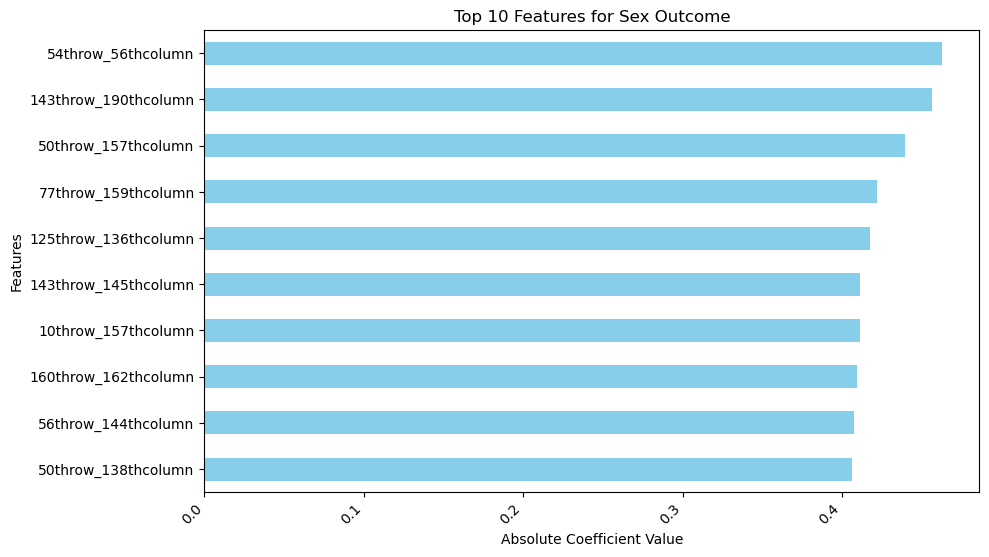

In [45]:
#Plotting the top 10 coefficents for Sex Outcome
plt.figure(figsize = (10, 6))
top_features.sort_values().plot(kind = 'barh', color = 'skyblue')
plt.title('Top 10 Features for Sex Outcome')
plt.ylabel('Features')
plt.xlabel('Absolute Coefficient Value')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

**Now, we will look at Feature Selection with ADHD_Outcome as the target**

In [46]:
model = LogisticRegression(max_iter = 5000)
model.fit(train_df.drop(columns = 'participant_id'), train_Solutions['ADHD_Outcome'])

LogisticRegression(max_iter=5000)

In [47]:
# Get coefficients for ADHD_Outcome prediction
coefficients = pd.Series(model.coef_[0], index = train_df.drop(columns = 'participant_id').columns)

In [48]:
# Select top features for ADHD_Outcome prediction
top_features = coefficients.abs().nlargest(10)
print(top_features)

MRI_Track_Scan_Location_1             0.793719
MRI_Track_Scan_Location_3             0.684729
Barratt_Barratt_P1_Occ_25             0.535580
SDQ_SDQ_Hyperactivity                 0.481083
PreInt_Demos_Fam_Child_Ethnicity_0    0.461300
8throw_96thcolumn                     0.427287
Barratt_Barratt_P1_Occ_35             0.402825
53throw_83thcolumn                    0.390234
52throw_60thcolumn                    0.366848
0throw_6thcolumn                      0.362610
dtype: float64


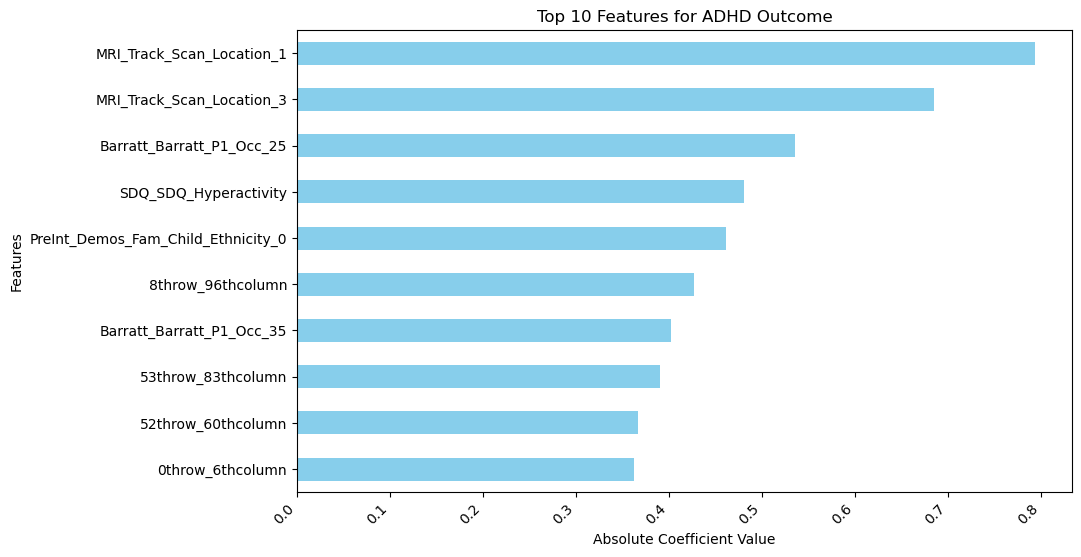

In [49]:
#Plotting the top 10 coefficents
plt.figure(figsize = (10, 6))
top_features.sort_values().plot(kind = 'barh', color = 'skyblue')
plt.title('Top 10 Features for ADHD Outcome')
plt.ylabel('Features')
plt.xlabel('Absolute Coefficient Value')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

**Using L1 regularization:**
- **Use L1 penalty**: Train a logistic regression model with L1 regularization. L1 regularization tends to shrink the coefficients of less important features to zero.
- **Select non-zero features:** Choose the features with non-zero coefficients.

**We will first use L1 regularization with Sex as the target.**

In [50]:
model = LogisticRegression(penalty = 'l1', solver = 'liblinear')
model.fit(logreg_sex_train, train_Solutions['Sex_F'])

LogisticRegression(penalty='l1', solver='liblinear')

In [51]:
selected_features_Sex = logreg_sex_train.columns[model.coef_[0] != 0]
print(selected_features_Sex)

Index(['0throw_1thcolumn', '0throw_6thcolumn', '0throw_16thcolumn',
       '0throw_22thcolumn', '0throw_124thcolumn', '1throw_2thcolumn',
       '1throw_3thcolumn', '1throw_8thcolumn', '1throw_119thcolumn',
       '1throw_142thcolumn',
       ...
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan'],
      dtype='object', length=429)


**We will now use L1 regularization with ADHD_Outcome as the target**

In [52]:
model = LogisticRegression(penalty = 'l1', solver = 'liblinear')
model.fit(train_df.drop(columns = 'participant_id'), train_Solutions['ADHD_Outcome'])

LogisticRegression(penalty='l1', solver='liblinear')

In [53]:
selected_features_ADHD = train_df.drop(columns = 'participant_id').columns[model.coef_[0] != 0]
print(selected_features_ADHD)

Index(['Basic_Demos_Study_Site_3', 'Basic_Demos_Study_Site_4',
       'PreInt_Demos_Fam_Child_Ethnicity_0',
       'PreInt_Demos_Fam_Child_Ethnicity_1', 'PreInt_Demos_Fam_Child_Race_1',
       'PreInt_Demos_Fam_Child_Race_8', 'MRI_Track_Scan_Location_1',
       'MRI_Track_Scan_Location_3', 'MRI_Track_Scan_Location_4',
       'Barratt_Barratt_P1_Edu_9',
       ...
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan'],
      dtype='object', length=264)


In [54]:
combined_features = list(set(selected_features_ADHD) | set(selected_features_Sex)) # union

X_train = X_train[combined_features]

# x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train)

## Create decision tree classifier with union of features

In [55]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Initialize the base classifier
xgb_classifier = XGBClassifier(objective = 'binary:logistic', n_estimators = 100, 
                               learning_rate = 0.1, max_depth = 5)

# Wrap with MultiOutputClassifier for multi-target classification
multioutput_classifier = MultiOutputClassifier(xgb_classifier)

# Train the model
multioutput_classifier.fit(X_train, y_train)

XGBoostError: [23:55:25] /Users/runner/work/xgboost/xgboost/src/data/data.cc:501: Check failed: this->labels.Size() % this->num_row_ == 0 (909 vs. 0) : Incorrect size for labels.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013af44355 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x000000013b01ac83 xgboost::MetaInfo::SetInfoFromHost(xgboost::Context const&, xgboost::StringView, xgboost::Json) + 3491
  [bt] (2) 3   libxgboost.dylib                    0x000000013b019df2 xgboost::MetaInfo::SetInfo(xgboost::Context const&, xgboost::StringView, xgboost::StringView) + 146
  [bt] (3) 4   libxgboost.dylib                    0x000000013af5c729 XGDMatrixSetInfoFromInterface + 233
  [bt] (4) 5   libffi.7.dylib                      0x000000010d967ead ffi_call_unix64 + 85
  [bt] (5) 6   ???                                 0x000000030a4c52b0 0x0 + 13057675952



### Predict with the union of common columns

In [27]:
participant_id = test_df['participant_id']

# X_test = test_df.drop(columns = ['participant_id'])[combined_features]

# y_pred = multioutput_classifier.predict(X_test)
multioutput_classifier.score(X_test, y_test)

0.5427631578947368

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(y_pred, columns = ['Predicted_Gender', 'Predicted_ADHD'])

# Combine participant IDs with predictions
result_df = pd.concat([participant_id.reset_index(drop = True), predictions_df], axis = 1)

# Print or save the DataFrame
print(result_df)

### Evaluate

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

def multi_output_accuracy(y_true, y_pred):
    # Ensure y_true and y_pred are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Compute accuracy for each target variable and return the mean
    return np.mean([accuracy_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

multi_output_scorer = make_scorer(multi_output_accuracy)

In [29]:
# Perform cross-validation on the training data
cv_scores = cross_val_score(multioutput_classifier, X_train, y_train, cv = 5, 
                               scoring = multi_output_scorer)

# Output the cross-validation results
print("Cross-validation scores for each fold:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))

Cross-validation scores for each fold: [0.72252747 0.75       0.73901099 0.6978022  0.70994475]
Mean CV score: 0.723857082144375


In [57]:
score = []

for i in range(0, 100):
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train)
    
    xgb_classifier = XGBClassifier(objective = 'binary:logistic', n_estimators = 100, 
                               learning_rate = 0.1, max_depth = 5)

    multioutput_classifier = MultiOutputClassifier(xgb_classifier)

    multioutput_classifier.fit(x_train, y_train)
    
    score.append(multioutput_classifier.score(x_test, y_test))

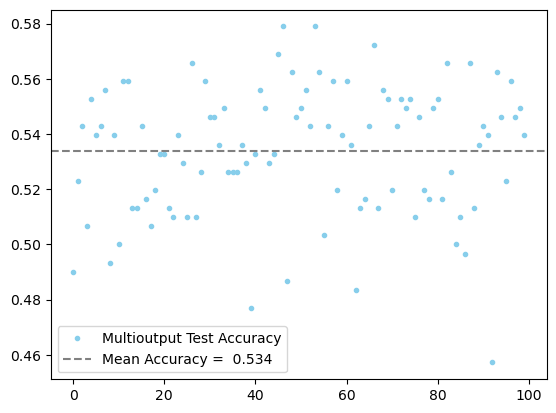

In [64]:
plt.plot(score, '.', lw = 1, color = 'skyblue', label = 'Multioutput Test Accuracy')
plt.axhline(y = np.mean(score), color = 'grey', ls = '--', label = 'Mean Accuracy = {0: .{1}f}'.format(np.mean(score), 3))

plt.legend()
plt.savefig('onedectree_score.pdf')
plt.show()

In [59]:
np.mean(score)

0.5339473684210526